In [103]:
import pandas as pd
import numpy as np
import os
import glob
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,GridSearchCV
import pickle
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.cloud import storage
import json
# from sklearn.ensemble import CatBoostClassifier

In [106]:
client = bigquery.Client()

print("Client creating using default project: {}".format(client.project))
query = """
 select * from `jm-ebg.EDA_MODEL.lable_data_with_extra_features`
 """
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    # location="US",
)  # API request - starts the query
df = query_job.to_dataframe()
df.shape
# df.to_csv('train_data.csv')

Client creating using default project: jm-ebg


(102571, 28)

In [139]:
import pandas as pd
df = pd.read_csv('1_2may_testing_labeled.csv',dtype={"user_pseudo_id":str})
df.shape

(12091, 22)

In [140]:
cat_cols = list(df.select_dtypes(include=['O']).columns)
float_cols = list(df.select_dtypes(include=[float]).columns)
int_cols = list(df.select_dtypes(include=[int]).columns)
int_cols.remove('label')

In [141]:
data={}
unwanted = {'(none)','(direct)','(not set)','(Other)'}  

In [142]:
def analysis_count(column_name,number):
    return df.groupby([column_name])[column_name].size().reset_index(name='count') \
                     .sort_values(['count'], ascending=False) \
                     .head(number).reset_index(drop=True)
def analysis_column(column_name,number):
    return df.groupby([column_name])[column_name].size().reset_index(name='count') \
                     .sort_values(['count'], ascending=False) \
                     .head(number)[column_name].tolist()

In [143]:
##data -> dictionary 
# data['placement'] =  analysis_column("placement",150)
# data['placement'] = [i for i in data['placement']  if i not in unwanted]
data['device_category_past'] =  analysis_column('device_category_past',4)
data['device_category_past'] = [i for i in data['device_category_past']  if i not in unwanted] 
data['mobile_brand_name_past'] =  analysis_column('mobile_brand_name_past',10)
data['mobile_brand_name_past'] = [i for i in data['mobile_brand_name_past']  if i not in unwanted] 
data['operating_system_past'] =  analysis_column('operating_system_past',5)
data['operating_system_past'] = [i for i in data['operating_system_past']  if i not in unwanted] 
data['os_version_past'] =  analysis_column('os_version_past',10)
data['os_version_past'] = [i for i in data['os_version_past']  if i not in unwanted] 
data['browser_past'] =  analysis_column('browser_past',8)
data['browser_past'] = [i for i in data['browser_past']  if i not in unwanted]
data['city_past'] =  analysis_column('city_past',160)
data['city_past'] = [i for i in data['city_past']  if i not in unwanted]
data['region_past'] =  analysis_column('region_past',50)
data['region_past'] = [i for i in data['region_past']  if i not in unwanted] 
data['ft_campaign_past'] =  analysis_column('ft_campaign_past',70)
data['ft_campaign_past'] = [i for i in data['ft_campaign_past']  if i not in unwanted]
data['ft_medium_past'] =  analysis_column('ft_medium_past',5)
data['ft_medium_past'] = [i for i in data['ft_medium_past']  if i not in unwanted] 
data['ft_source_past'] =  analysis_column('ft_source_past',10)
data['ft_source_past'] = [i for i in data['ft_source_past']  if i not in unwanted] 
data['utm_term_placement_past'] =  analysis_column('utm_term_placement_past',200)
data['utm_term_placement_past'] = [i for i in data['utm_term_placement_past']  if i not in unwanted]
# data['placement_past'] =  analysis_column('placement_past',150)
# data['placement_past'] = [i for i in data['placement_past']  if i not in unwanted]

In [144]:
# df['placement'].loc[df['placement'].apply(lambda x: (x not in data['placement']) )] = '(Others)'
df['device_category_past'].loc[df['device_category_past'].apply(lambda x: (x not in data['device_category_past']) )] = '(Others)'
df['mobile_brand_name_past'].loc[df['mobile_brand_name_past'].apply(lambda x: (x not in data['mobile_brand_name_past']) )] = '(Others)'
df['operating_system_past'].loc[df['operating_system_past'].apply(lambda x: (x not in data['operating_system_past']) )] = '(Others)'
df['os_version_past'].loc[df['os_version_past'].apply(lambda x: (x not in data['os_version_past']) )] = '(Others)'
df['browser_past'].loc[df['browser_past'].apply(lambda x: (x not in data['browser_past']) )] = '(Others)'
df['city_past'].loc[df['city_past'].apply(lambda x: (x not in data['city_past']) )] = '(Others)'
df['region_past'].loc[df['region_past'].apply(lambda x: (x not in data['region_past']) )] = '(Others)'
df['ft_campaign_past'].loc[df['ft_campaign_past'].apply(lambda x: (x not in data['ft_campaign_past']) )] = '(Others)'
df['ft_medium_past'].loc[df['ft_medium_past'].apply(lambda x: (x not in data['ft_medium_past']) )] = '(Others)'
df['ft_source_past'].loc[df['ft_source_past'].apply(lambda x: (x not in data['ft_source_past']) )] = '(Others)'
df['utm_term_placement_past'].loc[df['utm_term_placement_past'].apply(lambda x: (x not in data['utm_term_placement_past']) )] = '(Others)'
# df['placement_past'].loc[df['placement_past'].apply(lambda x: (x not in data['placement_past']) )] = '(Others)'

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [145]:
### replace the string int and float value
for i in cat_cols:
    df[i].fillna("Value_Not_Found", inplace = True)
for i in int_cols:
    df[i].fillna(-99999, inplace = True) 
for i in float_cols:
    df[i].fillna(-99999999.000, inplace = True) 

In [146]:
df.head()

,ProspectId,user_pseudo_id,visitStartTime,event_date,day_of_week_past,timeOnSite_past,device_category_past,mobile_brand_name_past,operating_system_past,os_version_past,...,city_past,ft_campaign_past,ft_source_past,ft_medium_past,utm_term_placement_past,mx_Last_Activity_Notes,ProspectActivityName_Max,mx_Last_Activity_done_by_Agent,mx_Sub_Dispostion,label
0,003e3eb8-a499-4e94-a0a4-a1f90d65c7aa,834139000.2,1683007316,20230502,3,0.000000,mobile,Infinix,Android,Android 11,...,Patna,(Others),(Others),(Others),(Others),ringing (pan card not available),Not Contactable,Not Contactable,Ringing,0
1,008a83af-1a2a-4528-87d3-a5af33013ad6,353319200.2,1682899533,20230501,2,1.474086,mobile,(Others),Android,(Others),...,Lucknow,Leads_Performance_Demat_Tier_2,google,cpc,(Others),Value_Not_Found,Not Interested,Value_Not_Found,Others,0
2,008a83af-1a2a-4528-87d3-a5af33013ad6,353319200.2,1682899533,20230501,2,0.188153,mobile,(Others),Android,(Others),...,Lucknow,Leads_Performance_Demat_Tier_2,google,cpc,(Others),Value_Not_Found,Not Interested,Value_Not_Found,Others,0
3,008a83af-1a2a-4528-87d3-a5af33013ad6,353319200.2,1682899533,20230501,2,1.897437,mobile,(Others),Android,(Others),...,Lucknow,Leads_Performance_Demat_Tier_2,google,cpc,(Others),Value_Not_Found,Not Interested,Value_Not_Found,Others,0
4,008a83af-1a2a-4528-87d3-a5af33013ad6,353319200.2,1682916115,20230501,2,21.324201,mobile,(Others),Android,(Others),...,Lucknow,Leads_Performance_Demat_Tier_2,google,cpc,(Others),Value_Not_Found,Not Interested,Value_Not_Found,Others,0


In [147]:
#categorical value handling
le = LabelEncoder()
for  i in cat_cols:
    df[i] = le.fit_transform(df[i])
    pickle.dump(le, open("label_encode/{}-esd-RF.pkl".format(i), 'wb'))

In [148]:
drop_cols = ['user_pseudo_id', 'visitStartTime', 'event_date','user_psudo_id_conv', 'ProspectId_conv', 'visitStartTime_conv',
       'date_conv', 'day_diff','device_category_past','ProspectID_LeadCreation','mx_Last_Activity_Notes']
df = df.drop(drop_cols, axis=1)

KeyError: "['user_psudo_id_conv' 'ProspectId_conv' 'visitStartTime_conv' 'date_conv'\n 'day_diff' 'ProspectID_LeadCreation'] not found in axis"

In [149]:
drop_cols = ['user_pseudo_id', 'visitStartTime', 'event_date','device_category_past','mx_Last_Activity_Notes']
df = df.drop(drop_cols, axis=1)

In [150]:
drop_cols = ['ProspectId']
df = df.drop(drop_cols, axis=1)

<AxesSubplot:xlabel='label', ylabel='mx_Last_Activity_done_by_Agent'>

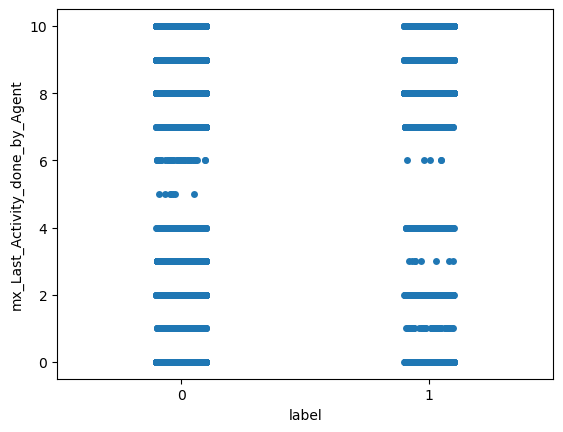

In [67]:
import seaborn as sns
sns.stripplot(df, x="label", y="mx_Last_Activity_done_by_Agent")


<AxesSubplot:xlabel='label', ylabel='ProspectActivityName_Max'>

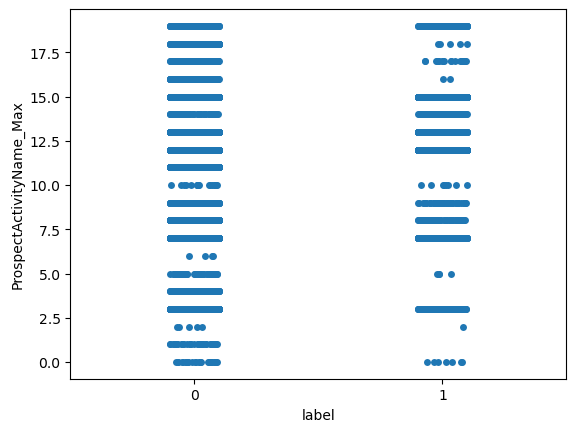

In [14]:
import seaborn as sns
sns.stripplot(df, x="label", y="ProspectActivityName_Max")

In [151]:
df = df.astype(float)

In [ ]:
g = sns.pairplot(df.sample(1000), hue="label")

In [16]:
df.dtypes

timeOnSite_past                   float64
day_of_week_past                  float64
device_category_past              float64
mobile_brand_name_past            float64
operating_system_past             float64
os_version_past                   float64
browser_past                      float64
region_past                       float64
city_past                         float64
ft_campaign_past                  float64
ft_medium_past                    float64
ft_source_past                    float64
utm_term_placement_past           float64
label                             float64
ProspectActivityName_Max          float64
mx_Last_Activity_done_by_Agent    float64
mx_Sub_Dispostion                 float64
dtype: object

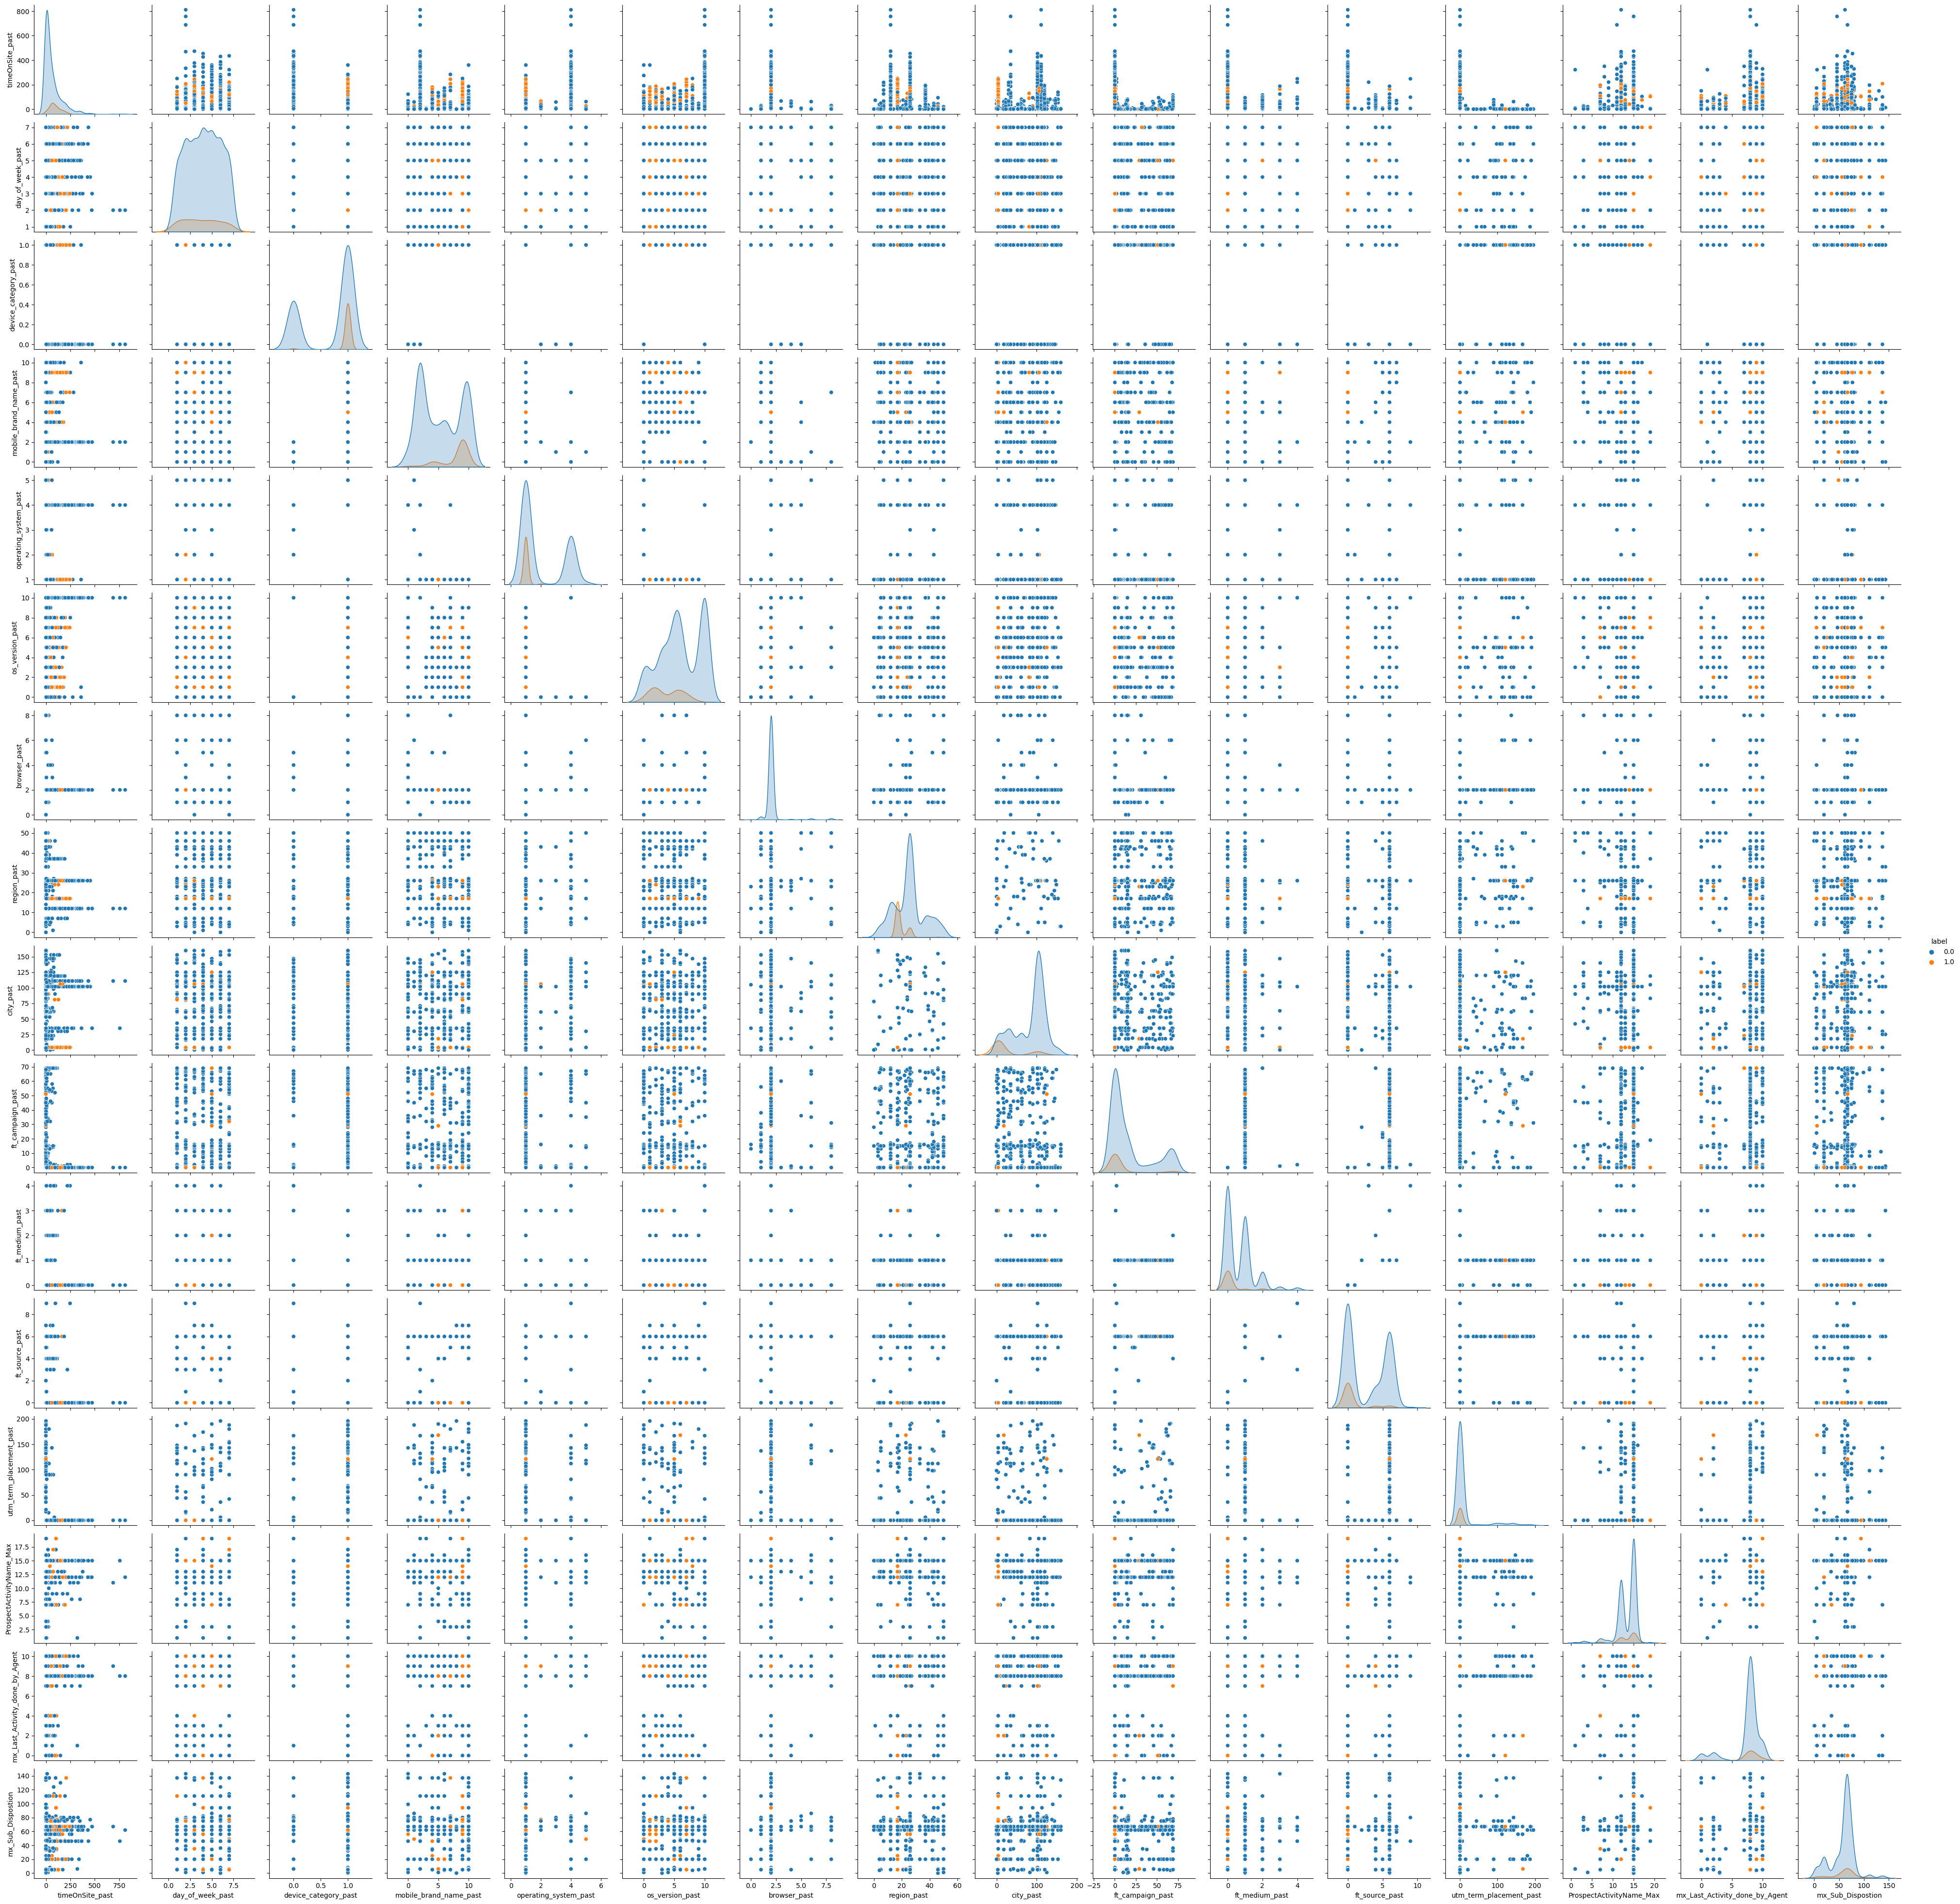

In [18]:
sns.pairplot(df.sample(1000), hue="label",diag_kind='kde')

In [313]:
df=df.astype(float)

In [152]:
df.head()

,day_of_week_past,timeOnSite_past,mobile_brand_name_past,operating_system_past,os_version_past,browser_past,region_past,city_past,ft_campaign_past,ft_source_past,ft_medium_past,utm_term_placement_past,ProspectActivityName_Max,mx_Last_Activity_done_by_Agent,mx_Sub_Dispostion,label
0,3.0,0.000000,3.0,0.0,3.0,2.0,4.0,68.0,0.0,0.0,0.0,0.0,9.0,3.0,46.0,0.0
1,2.0,1.474086,0.0,0.0,0.0,2.0,30.0,47.0,15.0,6.0,1.0,0.0,10.0,5.0,40.0,0.0
2,2.0,0.188153,0.0,0.0,0.0,2.0,30.0,47.0,15.0,6.0,1.0,0.0,10.0,5.0,40.0,0.0
3,2.0,1.897437,0.0,0.0,0.0,2.0,30.0,47.0,15.0,6.0,1.0,0.0,10.0,5.0,40.0,0.0
4,2.0,21.324201,0.0,0.0,0.0,2.0,30.0,47.0,15.0,6.0,1.0,0.0,10.0,5.0,40.0,0.0


In [215]:
df['day_of_week_past'].corr(df['label'])

0.015701981965326503

In [216]:
df['timeOnSite_past'].corr(df['label'])

0.008206279711640506

In [217]:
df['device_category_past'].corr(df['label'])

0.008930982240851953

In [218]:
df['mobile_brand_name_past'].corr(df['label'])

-0.015699581485661668

In [219]:
df['operating_system_past'].corr(df['label'])

-0.01851852592357565

In [220]:
df['os_version_past'].corr(df['label'])

0.054013634482449085

In [221]:
df['browser_past'].corr(df['label'])

-0.0040255706418836495

In [222]:
df['region_past'].corr(df['label'])

-0.020100688075757447

In [223]:
df['city_past'].corr(df['label'])

0.056711181438345463

In [224]:
df['ft_campaign_past'].corr(df['label'])

0.20939967557637668

In [225]:
df['ft_medium_past'].corr(df['label'])

0.13385001942289498

In [226]:
df['ft_source_past'].corr(df['label'])

-0.01820086704490599

In [227]:
df['utm_term_placement_past'].corr(df['label'])

-0.03397294070524703

In [228]:
df['ProspectActivityName_Max'].corr(df['label'])

-0.04374339971553377

In [229]:
df['mx_Last_Activity_done_by_Agent'].corr(df['label'])

-0.038090722334771565

In [230]:
df['mx_Sub_Dispostion'].corr(df['label'])

-0.10718907278215115

In [37]:
new_index = pd.RangeIndex(16)
new_df = pd.DataFrame(np.nan, index=new_index, columns=df.columns)

In [39]:
df2 = new_df.rename(index={0: 'timeOnSite_past', 1: 'day_of_week_past', 2: 'mobile_brand_name_past', 3:'operating_system_past',4:'os_version_past',5:'browser_past',6:'region_past',7:'city_past',8:'ft_campaign_past',9:'ft_medium_past',10:'ft_source_past',11:'utm_term_placement_past',12:'label',13:'ProspectActivityName_Max',14:'mx_Last_Activity_done_by_Agent',15:'mx_Sub_Dispostion',})

In [47]:
df2=df2.astype(float)
df=df.astype(float)

In [74]:
columns

['timeOnSite_past',
 'day_of_week_past',
 'mobile_brand_name_past',
 'operating_system_past',
 'os_version_past',
 'browser_past',
 'region_past',
 'city_past',
 'ft_campaign_past',
 'ft_medium_past',
 'ft_source_past',
 'utm_term_placement_past',
 'label',
 'ProspectActivityName_Max',
 'mx_Last_Activity_done_by_Agent',
 'mx_Sub_Dispostion']

In [81]:
for col1 in columns :
    for col in columns:
        df2[col]=df[col1].corr(df[col])
    

In [95]:
df['timeOnSite_past'].corr(df['day_of_week_past'])

0.02497123903261969

In [89]:
df.iloc[0][0]

0.6823011833333333

In [101]:
columns=list(df)
for i in range(16):
    for j in range(16):
        df2.iloc[i][j]=df.iloc[:,i].corr(df.iloc[:,j])

In [102]:
df2

,timeOnSite_past,day_of_week_past,mobile_brand_name_past,operating_system_past,os_version_past,browser_past,region_past,city_past,ft_campaign_past,ft_medium_past,ft_source_past,utm_term_placement_past,label,ProspectActivityName_Max,mx_Last_Activity_done_by_Agent,mx_Sub_Dispostion
timeOnSite_past,1.000000,0.024971,-0.318791,0.458820,0.407093,-0.065007,-0.274753,0.091228,-0.288106,-0.325419,-0.476983,-0.188557,0.103880,-0.004479,0.072794,0.030547
day_of_week_past,0.024971,1.000000,0.004995,0.005091,0.017077,0.002782,-0.002351,0.014812,0.005843,0.009276,-0.001597,-0.014000,0.016296,0.000337,0.005904,-0.001326
mobile_brand_name_past,-0.318791,0.004995,1.000000,-0.762922,-0.443319,-0.109790,0.038227,-0.204600,0.371010,0.334321,0.283038,0.045056,0.222185,0.055144,-0.174967,-0.046307
operating_system_past,0.458820,0.005091,-0.762922,1.000000,0.638019,0.116573,-0.086448,0.306199,-0.312632,-0.307062,-0.390647,-0.066139,-0.229905,-0.053753,0.184179,0.064068
os_version_past,0.407093,0.017077,-0.443319,0.638019,1.000000,-0.108767,-0.092874,0.263684,-0.188360,-0.167392,-0.303025,-0.135947,-0.177155,-0.008694,0.119848,0.046095
browser_past,-0.065007,0.002782,-0.109790,0.116573,-0.108767,1.000000,0.039281,-0.006142,0.015731,0.012909,0.050811,0.048664,-0.037785,-0.013305,0.015624,0.005945
region_past,-0.274753,-0.002351,0.038227,-0.086448,-0.092874,0.039281,1.000000,0.141261,0.133624,0.146833,0.206744,0.081349,-0.190662,-0.009139,-0.019811,-0.005078
city_past,0.091228,0.014812,-0.204600,0.306199,0.263684,-0.006142,0.141261,1.000000,0.026589,0.025384,-0.087738,-0.046314,-0.413543,-0.000042,-0.030771,0.008564
ft_campaign_past,-0.288106,0.005843,0.371010,-0.312632,-0.188360,0.015731,0.133624,0.026589,1.000000,0.709349,0.601634,0.240824,-0.134635,-0.004905,-0.146114,-0.078807
ft_medium_past,-0.325419,0.009276,0.334321,-0.307062,-0.167392,0.012909,0.146833,0.025384,0.709349,1.000000,0.760596,0.073134,-0.154864,-0.018355,-0.128097,-0.064249


In [118]:
df.head()

,timeOnSite_past,day_of_week_past,mobile_brand_name_past,operating_system_past,os_version_past,browser_past,region_past,city_past,ft_campaign_past,ft_medium_past,ft_source_past,utm_term_placement_past,label,ProspectActivityName_Max,mx_Last_Activity_done_by_Agent,mx_Sub_Dispostion
0,0.682301,5.0,0.0,4.0,0.0,5.0,46.0,3.0,48.0,1.0,6.0,71.0,0.0,12.0,8.0,62.0
1,35.725837,1.0,4.0,1.0,5.0,2.0,26.0,102.0,0.0,0.0,0.0,0.0,0.0,15.0,8.0,20.0
2,0.462754,4.0,6.0,1.0,3.0,2.0,42.0,32.0,39.0,1.0,6.0,142.0,0.0,15.0,8.0,62.0
3,24.002012,6.0,9.0,1.0,3.0,2.0,43.0,61.0,65.0,1.0,6.0,0.0,0.0,15.0,2.0,113.0
4,4.844952,6.0,9.0,1.0,6.0,2.0,26.0,102.0,0.0,0.0,0.0,0.0,0.0,12.0,8.0,20.0


In [153]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.ensemble import BalancedBaggingClassifier

In [160]:
df['label'].value_counts()

0.0    11987
1.0      104
Name: label, dtype: int64

In [316]:
A=df.drop(['label','utm_term_placement_past','ft_source_past','ft_medium_past','ft_campaign_past','city_past','region_past','browser_past','os_version_past','operating_system_past','mx_Last_Activity_done_by_Agent','mx_Sub_Dispostion'],axis=1)

In [121]:
B=df.drop(['label','day_of_week_past','ProspectActivityName_Max','timeOnSite_past','mobile_brand_name_past'],axis=1)

In [319]:
A.head()

,timeOnSite_past,day_of_week_past,mobile_brand_name_past,ProspectActivityName_Max
0,0.682301,5.0,0.0,12.0
1,35.725837,1.0,4.0,15.0
2,0.462754,4.0,6.0,15.0
3,24.002012,6.0,9.0,15.0
4,4.844952,6.0,9.0,12.0


In [161]:
X = df.drop(['label'], axis=1)
y = df.label

In [162]:
X=X.loc[:,['timeOnSite_past', 'day_of_week_past', 'mobile_brand_name_past',
       'operating_system_past', 'os_version_past', 'browser_past',
       'region_past', 'city_past', 'ft_campaign_past', 'ft_medium_past',
       'ft_source_past', 'utm_term_placement_past',
        'ProspectActivityName_Max',
       'mx_Last_Activity_done_by_Agent', 'mx_Sub_Dispostion']]

In [157]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.25, stratify=y)

In [322]:
A_train, A_test, y_train, y_test=train_test_split(A, y, test_size=.25, stratify=y)

In [123]:
B_train, B_test, y_train, y_test=train_test_split(B, y, test_size=.25, stratify=y)

In [158]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


ss_train = PowerTransformer()
X_train = ss_train.fit_transform(X_train)

ss_test = PowerTransformer()
X_test = ss_test.fit_transform(X_test)
X=ss_test.fit_transform(X)

In [276]:
ss_train = QuantileTransformer()
A_train = ss_train.fit_transform(A_train)

ss_test = QuantileTransformer()
A_test = ss_test.fit_transform(A_test)

In [129]:
ss_train = QuantileTransformer()
B_train = ss_train.fit_transform(B_train)

ss_test = QuantileTransformer()
B_test = ss_test.fit_transform(B_test)

In [135]:
bbc = BalancedBaggingClassifier(random_state=69)
bbc.fit(X_train, y_train)
BalancedBaggingClassifier(...)
y_pred = bbc.predict(X_test)

In [137]:
#Fitting Logistic Regression to the training set  
from sklearn.linear_model import LogisticRegression  
classifier= LogisticRegression(random_state=0,max_iter=1000000)  
classifier.fit(X_train, y_train) 

LogisticRegression(max_iter=1000000, random_state=0)

In [329]:
bbc = BalancedBaggingClassifier(random_state=42)
bbc.fit(A_train, y_train)
BalancedBaggingClassifier(...)
y_pred = bbc.predict(A_test)

In [126]:
bbc = BalancedBaggingClassifier(random_state=42)
bbc.fit(B_train, y_train)
BalancedBaggingClassifier(...)
y_pred = bbc.predict(B_test)

In [159]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score

y_pred = classifier.predict(X_test)
#y_pred = [1 if val >= 0.50 else 0 for val in y_pred_prob[:,1]]
f1 = f1_score(y_test, y_pred)
print("accuracy : ", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("roc auc : ", roc_auc_score(y_test, y_pred))
print("recall : ", recall_score(y_test, y_pred))
print("precision : ", precision_score(y_test, y_pred))
print("f1 score : ",f1 )

print ("----------------------")
y_pred = bbc.predict(X_test)
#y_pred = [1 if val >= 0.50 else 0 for val in y_pred_prob[:,1]]
f1 = f1_score(y_test, y_pred)
print("accuracy : ", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("roc auc : ", roc_auc_score(y_test, y_pred))
print("recall : ", recall_score(y_test, y_pred))
print("precision : ", precision_score(y_test, y_pred))
print("f1 score : ",f1 )

print ("----------------------")

accuracy :  0.9616275223288124
[[2907   90]
 [  26    0]]
roc auc :  0.484984984984985
recall :  0.0
precision :  0.0
f1 score :  0.0
----------------------
accuracy :  0.9649354945418458
[[2916   81]
 [  25    1]]
roc auc :  0.5057172557172558
recall :  0.038461538461538464
precision :  0.012195121951219513
f1 score :  0.01851851851851852
----------------------


In [331]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score

y_pred =bbc.predict(A)
#y_pred = [1 if val >= 0.50 else 0 for val in y_pred_prob[:,1]]
f1 = f1_score(y, y_pred)
print("accuracy : ", accuracy_score(y, y_pred))
print(confusion_matrix(y, y_pred))
print("roc auc : ", roc_auc_score(y, y_pred))
print("recall : ", recall_score(y, y_pred))
print("precision : ", precision_score(y, y_pred))
print("f1 score : ",f1 )

print ("----------------------")

accuracy :  0.6348578058125591
[[61180 29824]
 [ 7629  3938]]
roc auc :  0.506364712722411
recall :  0.34045128382467366
precision :  0.11664000947811148
f1 score :  0.17375190275541044
----------------------


In [131]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score

y_pred = classifier.predict(B)
#y_pred = [1 if val >= 0.50 else 0 for val in y_pred_prob[:,1]]
f1 = f1_score(y, y_pred)
print("accuracy : ", accuracy_score(y, y_pred))
print(confusion_matrix(y, y_pred))
print("roc auc : ", roc_auc_score(y, y_pred))
print("recall : ", recall_score(y, y_pred))
print("precision : ", precision_score(y, y_pred))
print("f1 score : ",f1 )

print ("----------------------")

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


accuracy :  0.8872293338273001
[[91004     0]
 [11567     0]]
roc auc :  0.5
recall :  0.0
precision :  0.0
f1 score :  0.0
----------------------


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [211]:
filename = 'model/Dhawal_blagging.pkl'

pickle.dump(bbc, open(filename, 'wb'))

In [153]:
bbc.features_in_

AttributeError: 'BalancedBaggingClassifier' object has no attribute 'features_in_'